# Genetic Algorithm Test for Musical Narrative Generation
This notebook demonstrates the use of a Non-dominated Sorting Genetic Algorithm II (NSGA-II) to generate musical pieces that align with a predefined narrative structure. The process involves:
1. Defining a narrative and its tension curve.
2. Loading character-specific musical motifs.
3. Setting up the genetic algorithm parameters.
4. Generating harmonic progressions using a context-free grammar.
5. Combining motifs and harmonies, evaluating them against multiple objectives (key compatibility, motif recognition, tension alignment).
6. Visualizing results and selecting optimal solutions.

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from narrative_example import *
from harmony_grammar import *
from utils import *
from genetic_algorithm import *
from tension_model.tension_ribbons import *
from narrative_tension import *
import pickle
import music21
import numpy as np
import itertools

## 1. Narrative Setup
First, we create an example narrative structure and compute its overall tension curve. This tension curve will serve as a target for the generated music.

In [3]:
span = create_example_narrative_simple()
span_tension = span.compute_tension_curve()

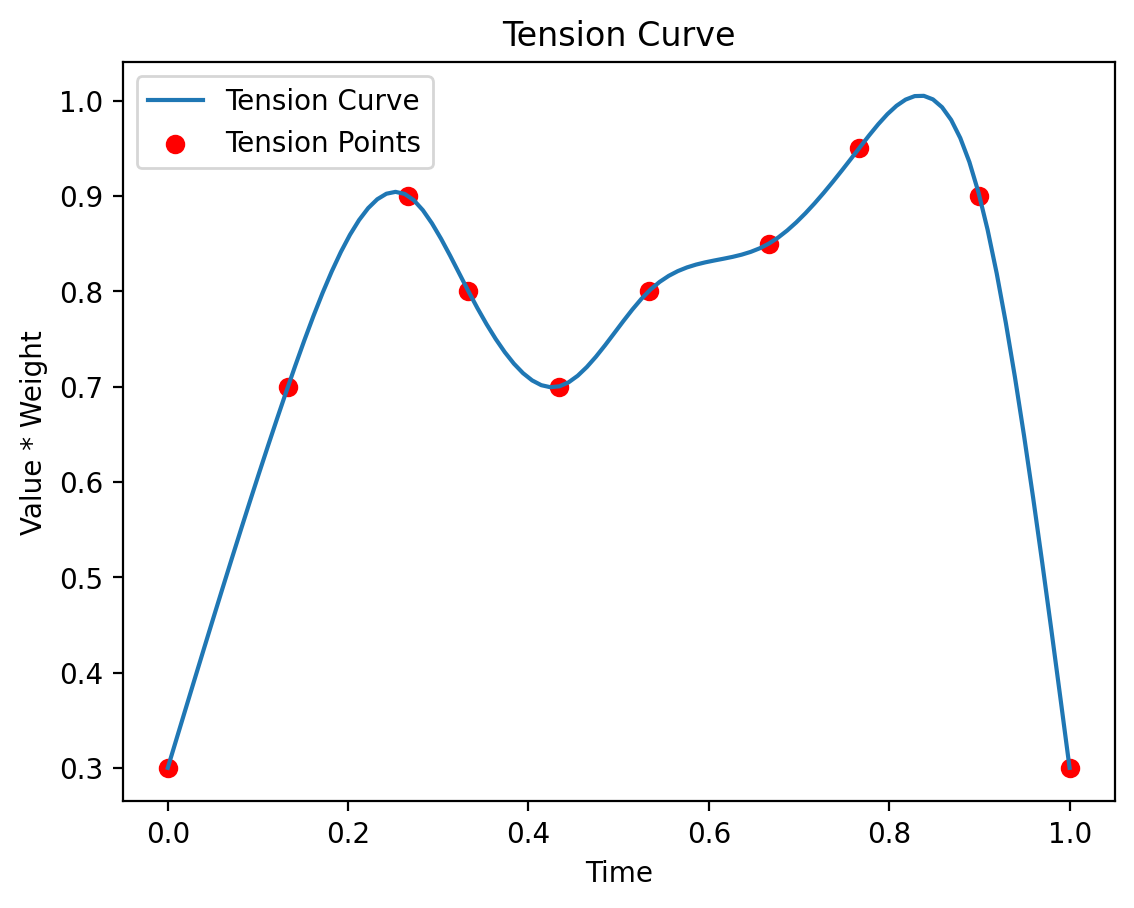

In [4]:
span_tension.plot()

We also extract the tension curve for each individual plot atom within the narrative.

In [5]:
tension_curve_atom = [atom.get_tension_curve() for atom in span.plot_atoms]

## 2. Motif Loading and Character Association
Musical motifs for different characters (Hero, Villain, Victim) are loaded from pickled files. A helper function `get_characters_motif` is defined to retrieve motifs based on character names. These motifs are then associated with the characters appearing in each plot atom of our narrative.

In [6]:
motif_hero = pickle.load(open("motif_hero.pkl", "rb"))
motif_villain = pickle.load(open("motif_villain.pkl", "rb"))
motif_victim = pickle.load(open("motif_victim.pkl", "rb"))

# Function just to test, in real use get tension curve using Motif Generator
def get_characters_motif(character):
    if character.name == "Hero":
        return motif_hero
    elif character.name == "Villain":
        return motif_villain
    elif character.name == "Victim":
        return motif_victim
    else:
        print("Unknown character")
        return None

In [7]:
characters_motif = {}
unique_characters = set()
motifs_per_atom = []
protagonist_indeces = []

for atom in span.plot_atoms:
    current_atom = []
    protagonist_indeces.append(-1)
    for i, role in enumerate(atom.roles):
        character = role[1]
        unique_characters.add(character)
        if characters_motif.get(character) is None:
            motif = get_characters_motif(character)
            characters_motif[character] = motif
        else:
            motif = characters_motif[character]
        if character == span.protagonist:
            protagonist_indeces[-1] = i
        current_atom.append(motif)
    motifs_per_atom.append(current_atom)

The musical key of the protagonist is determined, which will be used later for evaluating key compatibility.

In [8]:
protagonist_key = Key(root=NOTE_TO_ROOT[characters_motif[span.protagonist].key], is_major=characters_motif[span.protagonist].is_major)

## 3. Genetic Algorithm Setup
Parameters for the genetic algorithm are defined, including population size, number of bars per plot atom, motif length, and the total number of atoms and bars.

In [9]:
pop_size = 200
bars_per_atom = 8
motif_length = 2
n_atoms = len(span.plot_atoms)
total_bars = bars_per_atom*n_atoms

## 4. Harmony Grammar and Progression Generation
A `HarmonyGrammar` is initialized and used to generate a set of all possible 8-bar harmonic progressions. These progressions will form the genetic material for the algorithm.

In [10]:
grammar = HarmonyGrammar()

In [11]:
all_progressions = grammar.generate_all_progressions(min_length=8, max_length=8, max_depth=7)

In [12]:
print("All Progressions len: ", len(all_progressions))

All Progressions len:  5928


## 5. Motif-Harmony Combination and Evaluation Setup
The tension curves for each atom are interpolated to match the desired granularity. Then, `MotifHarmonicCombiner` objects are created for each plot atom. These combiners are responsible for merging motifs with harmonic progressions and evaluating the resulting musical segments.

In [13]:
n_smallest_unit = bars_per_atom*4*4
tension_points_atom = [curve.interpolate(n_smallest_unit)[1] for curve in tension_curve_atom]

In [14]:
combiners = []
for motifs, protagonist_index, tension_points in zip(motifs_per_atom, protagonist_indeces, tension_points_atom):
    combiners.append(MotifHarmonicCombiner(motifs, protagonist_index, tension_points, bars_per_atom, motif_length))

## 6. Running the NSGA-II Algorithm
The NSGA-II algorithm is run independently for each plot atom. For each atom, an initial population of musical segments is created using the generated harmonic progressions. The algorithm then evolves this population over a number of generations, optimizing for three objectives:
1. Key Compatibility: How well the music fits the protagonists key.
2. Character Motif Recognition: How clearly the characters motifs are identifiable.
3. Tension Alignment: How well the musics tension curve matches the target tension for that atom.

In [15]:
pop_size = 200
n_generations = 200
nsga2s = []
results = []
for combiner in combiners:
    initial_population = combiner.create_initial_population(all_progressions, pop_size)
    nsga2 = NSGAII(population_size=pop_size, objectives=[combiner.evaluate_key_compatibility, combiner.evaluate_character_motif_recognition, combiner.evaluate_tension_alignment])
    results.append(nsga2.evolve(initial_population, n_generations))
    nsga2s.append(nsga2)

Generation 1/200
Generation 2/200
Generation 2/200
Generation 3/200
Generation 3/200
Generation 4/200
Generation 4/200
Generation 5/200
Generation 5/200
Generation 6/200
Generation 6/200
Generation 7/200
Generation 7/200
Generation 8/200
Generation 8/200
Generation 9/200
Generation 9/200
Generation 10/200
Generation 10/200
Generation 11/200
Generation 11/200
Generation 12/200
Generation 12/200
Generation 13/200
Generation 13/200
Generation 14/200
Generation 14/200
Generation 15/200
Generation 15/200
Generation 16/200
Generation 16/200
Generation 17/200
Generation 17/200
Generation 18/200
Generation 18/200
Generation 19/200
Generation 19/200
Generation 20/200
Generation 20/200
Generation 21/200
Generation 21/200
Generation 22/200
Generation 22/200
Generation 23/200
Generation 23/200
Generation 24/200
Generation 24/200
Generation 25/200
Generation 25/200
Generation 26/200
Generation 26/200
Generation 27/200
Generation 27/200
Generation 28/200
Generation 28/200
Generation 29/200
Generatio

## 7. Results Visualization
After the evolution, the objective values for the final population and the Pareto front (the set of non-dominated solutions) are visualized for each plot atom. This helps in understanding the trade-offs between the different objectives.

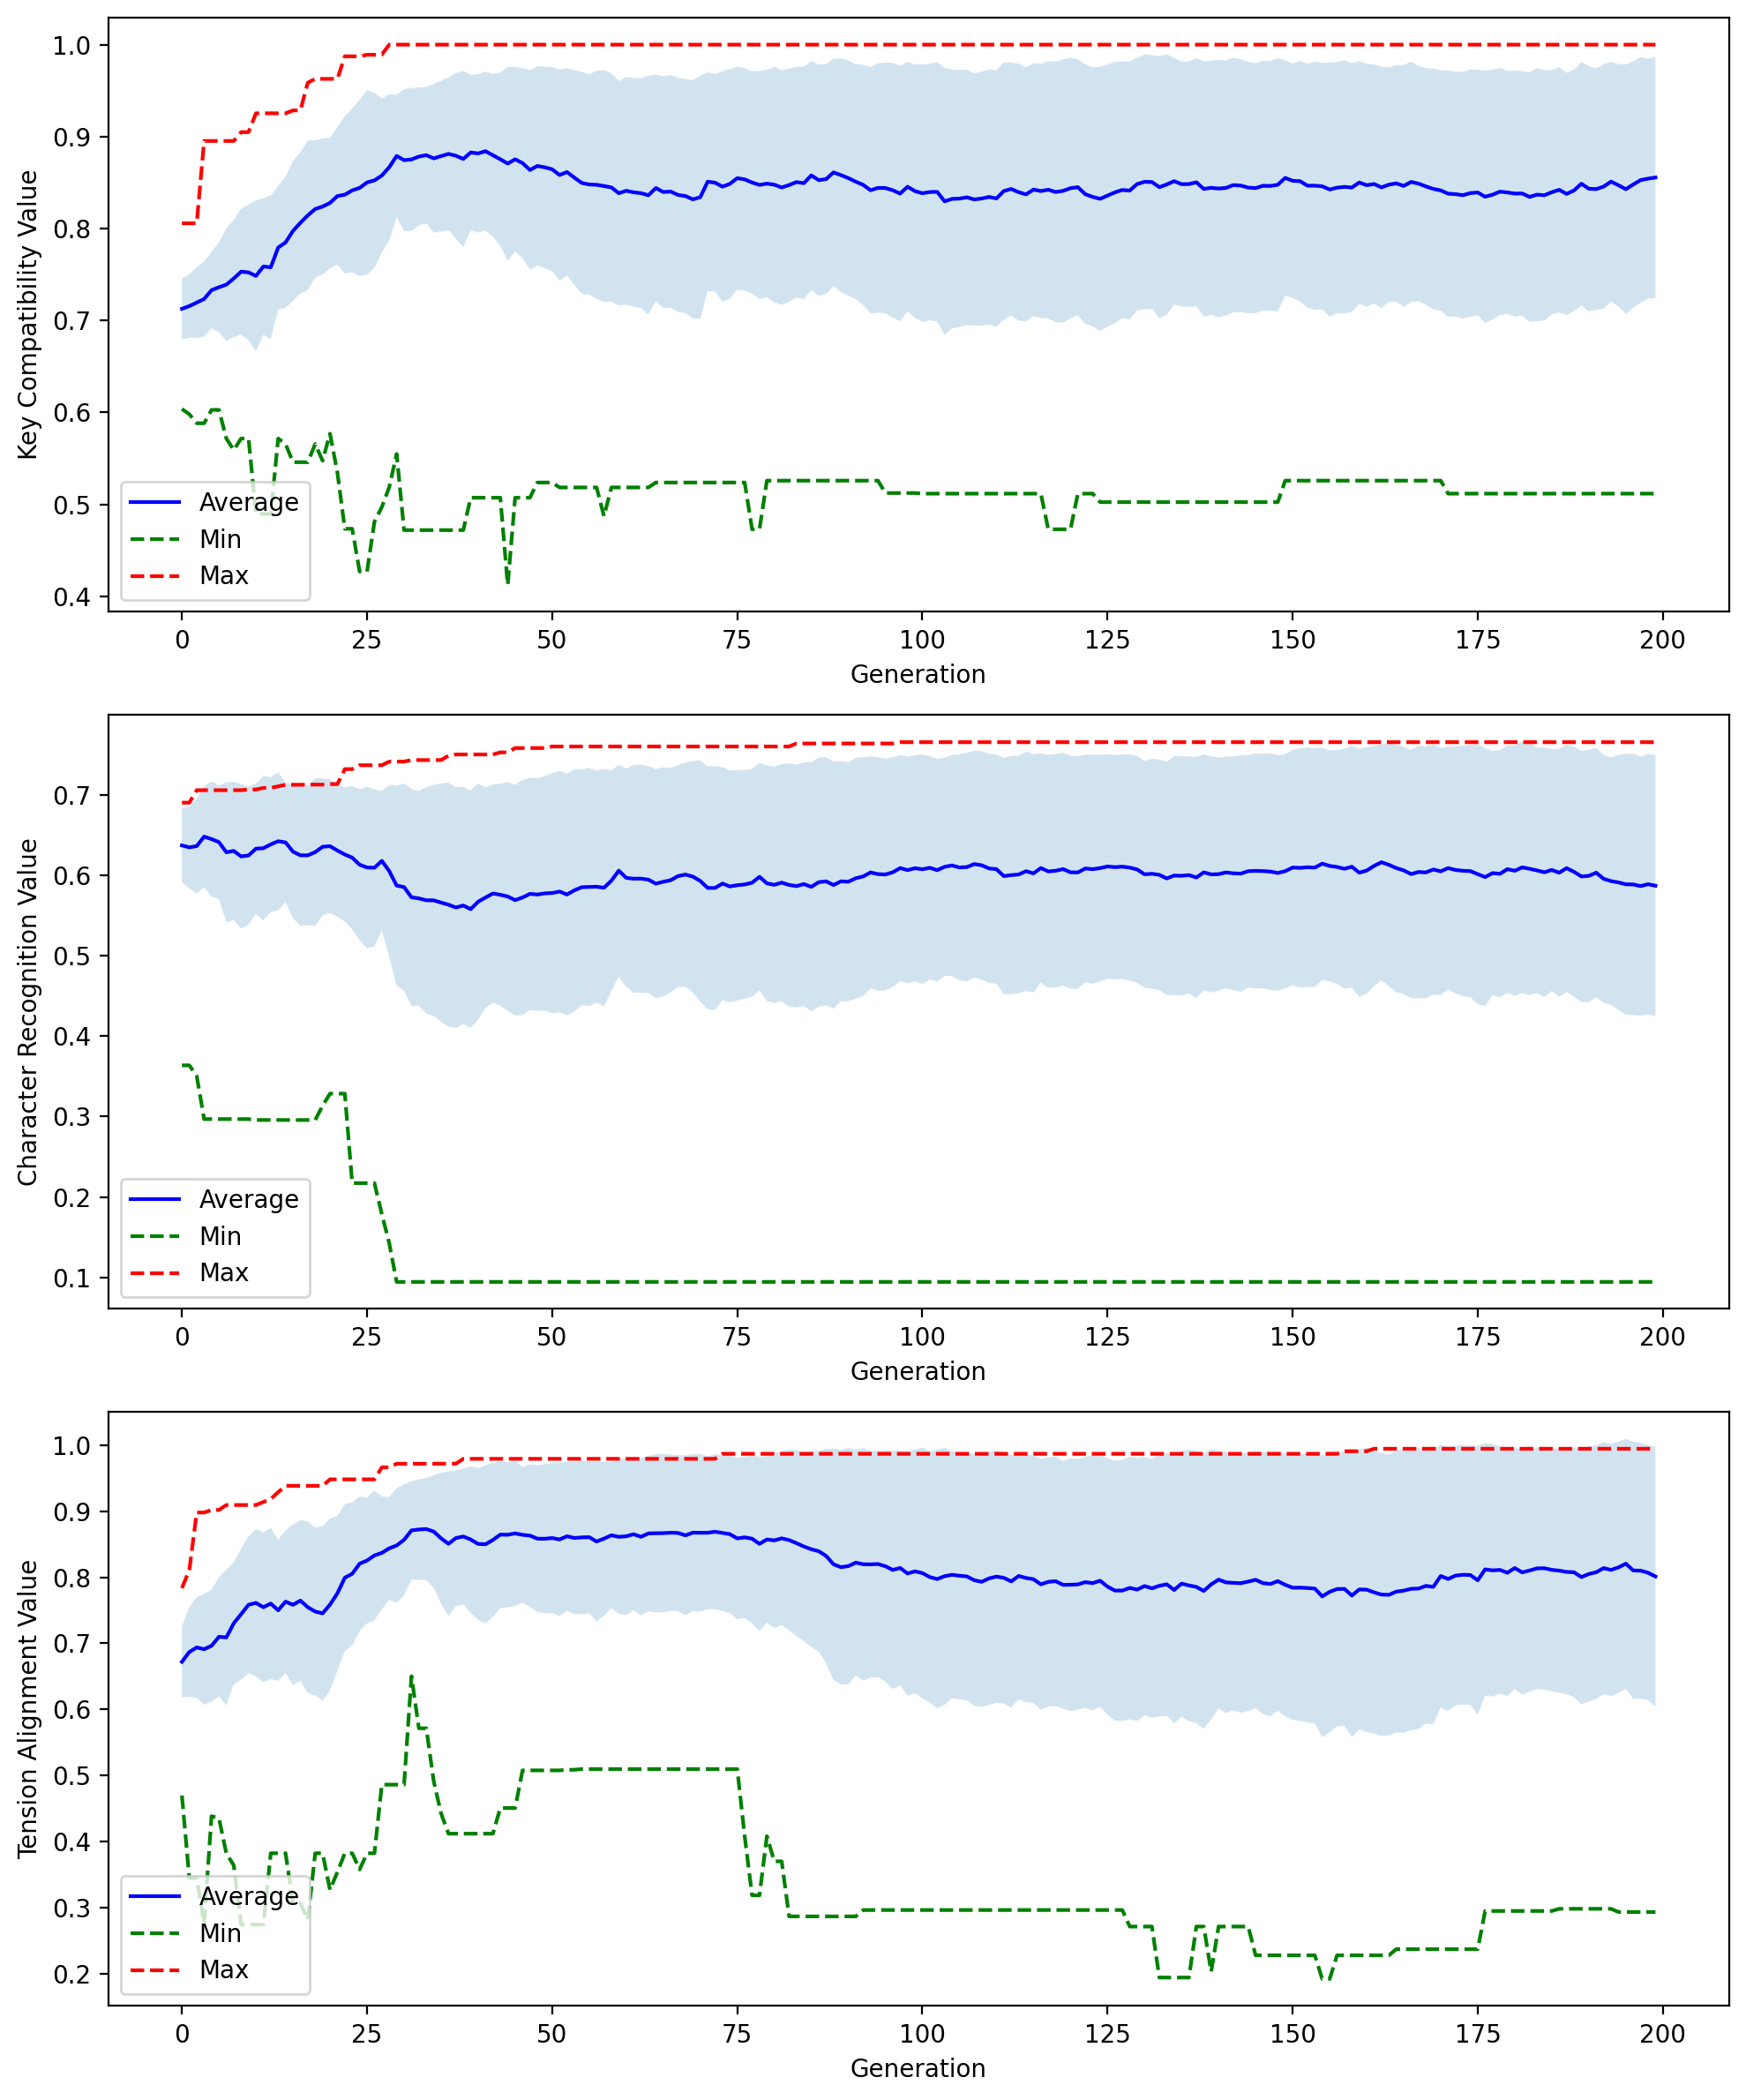

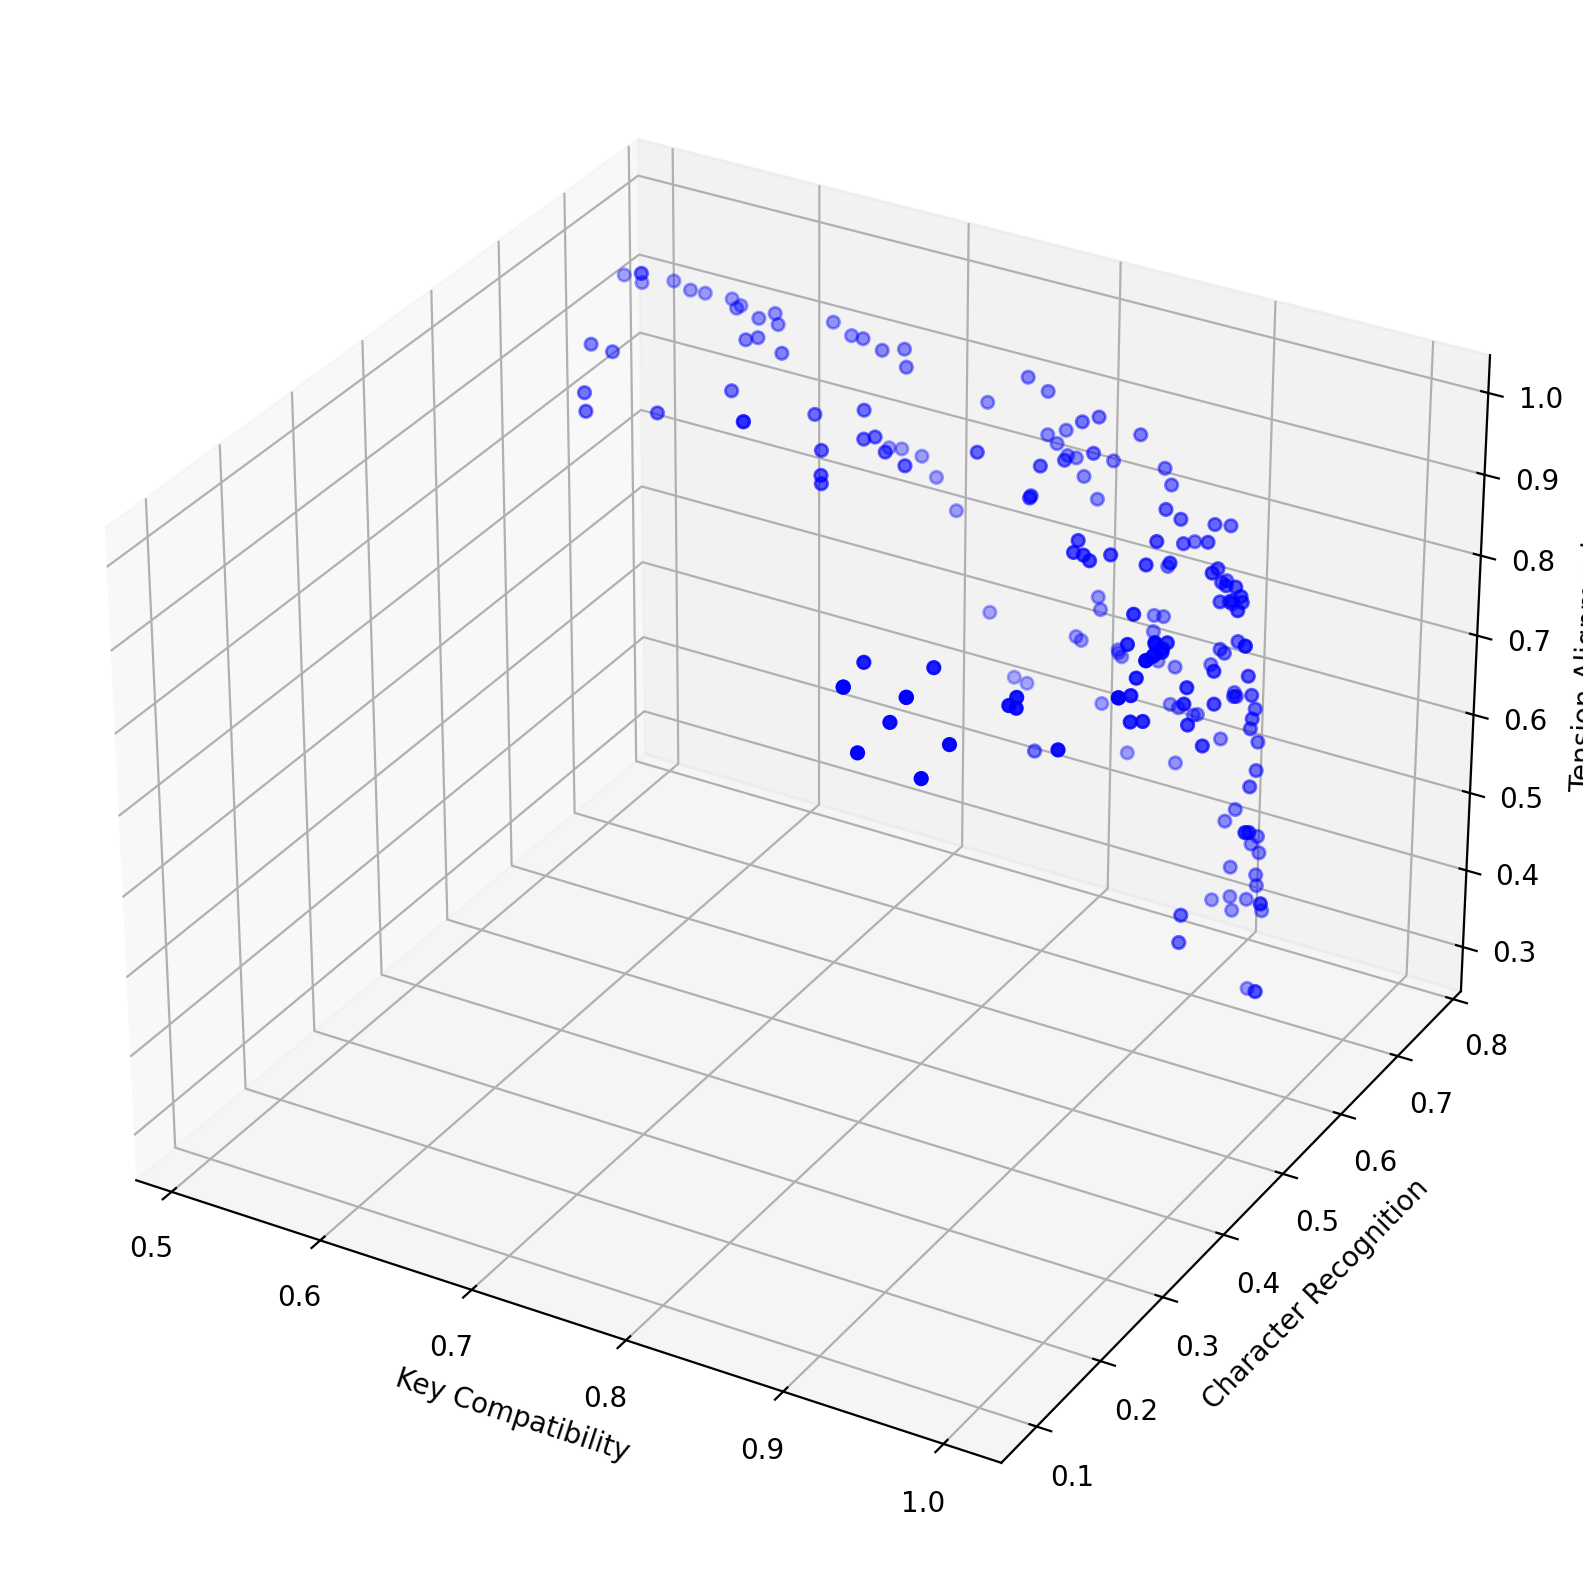

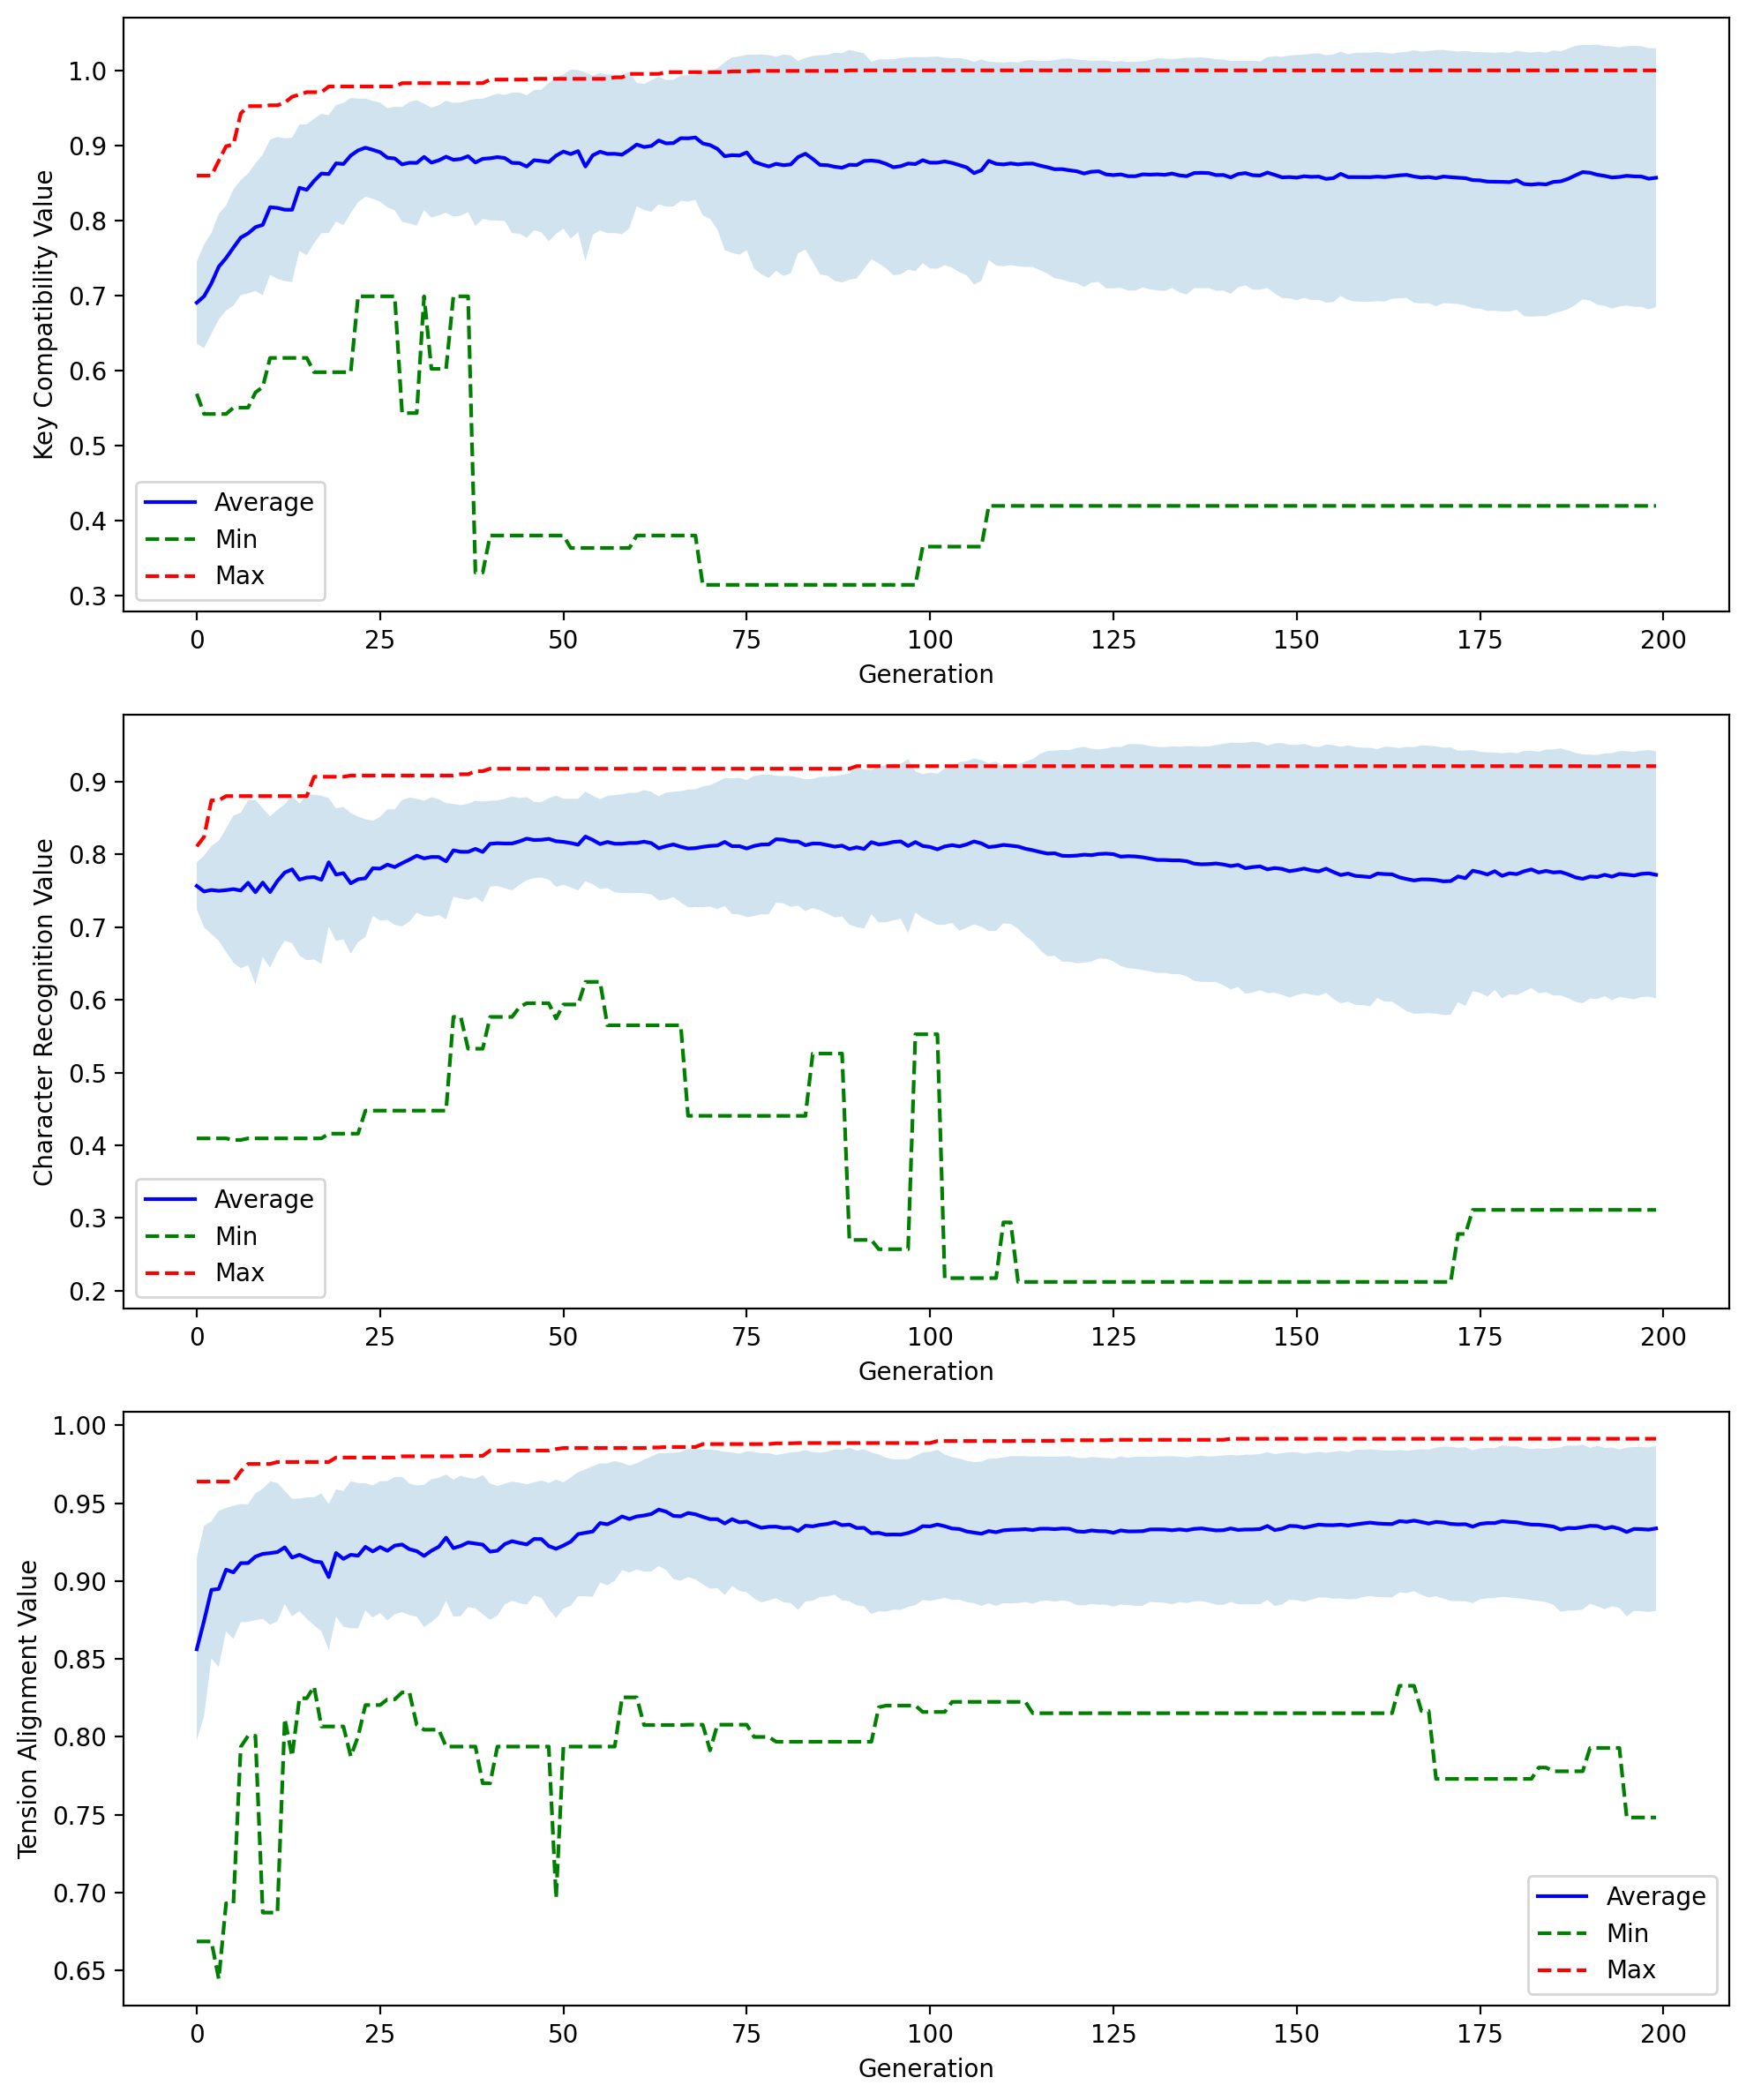

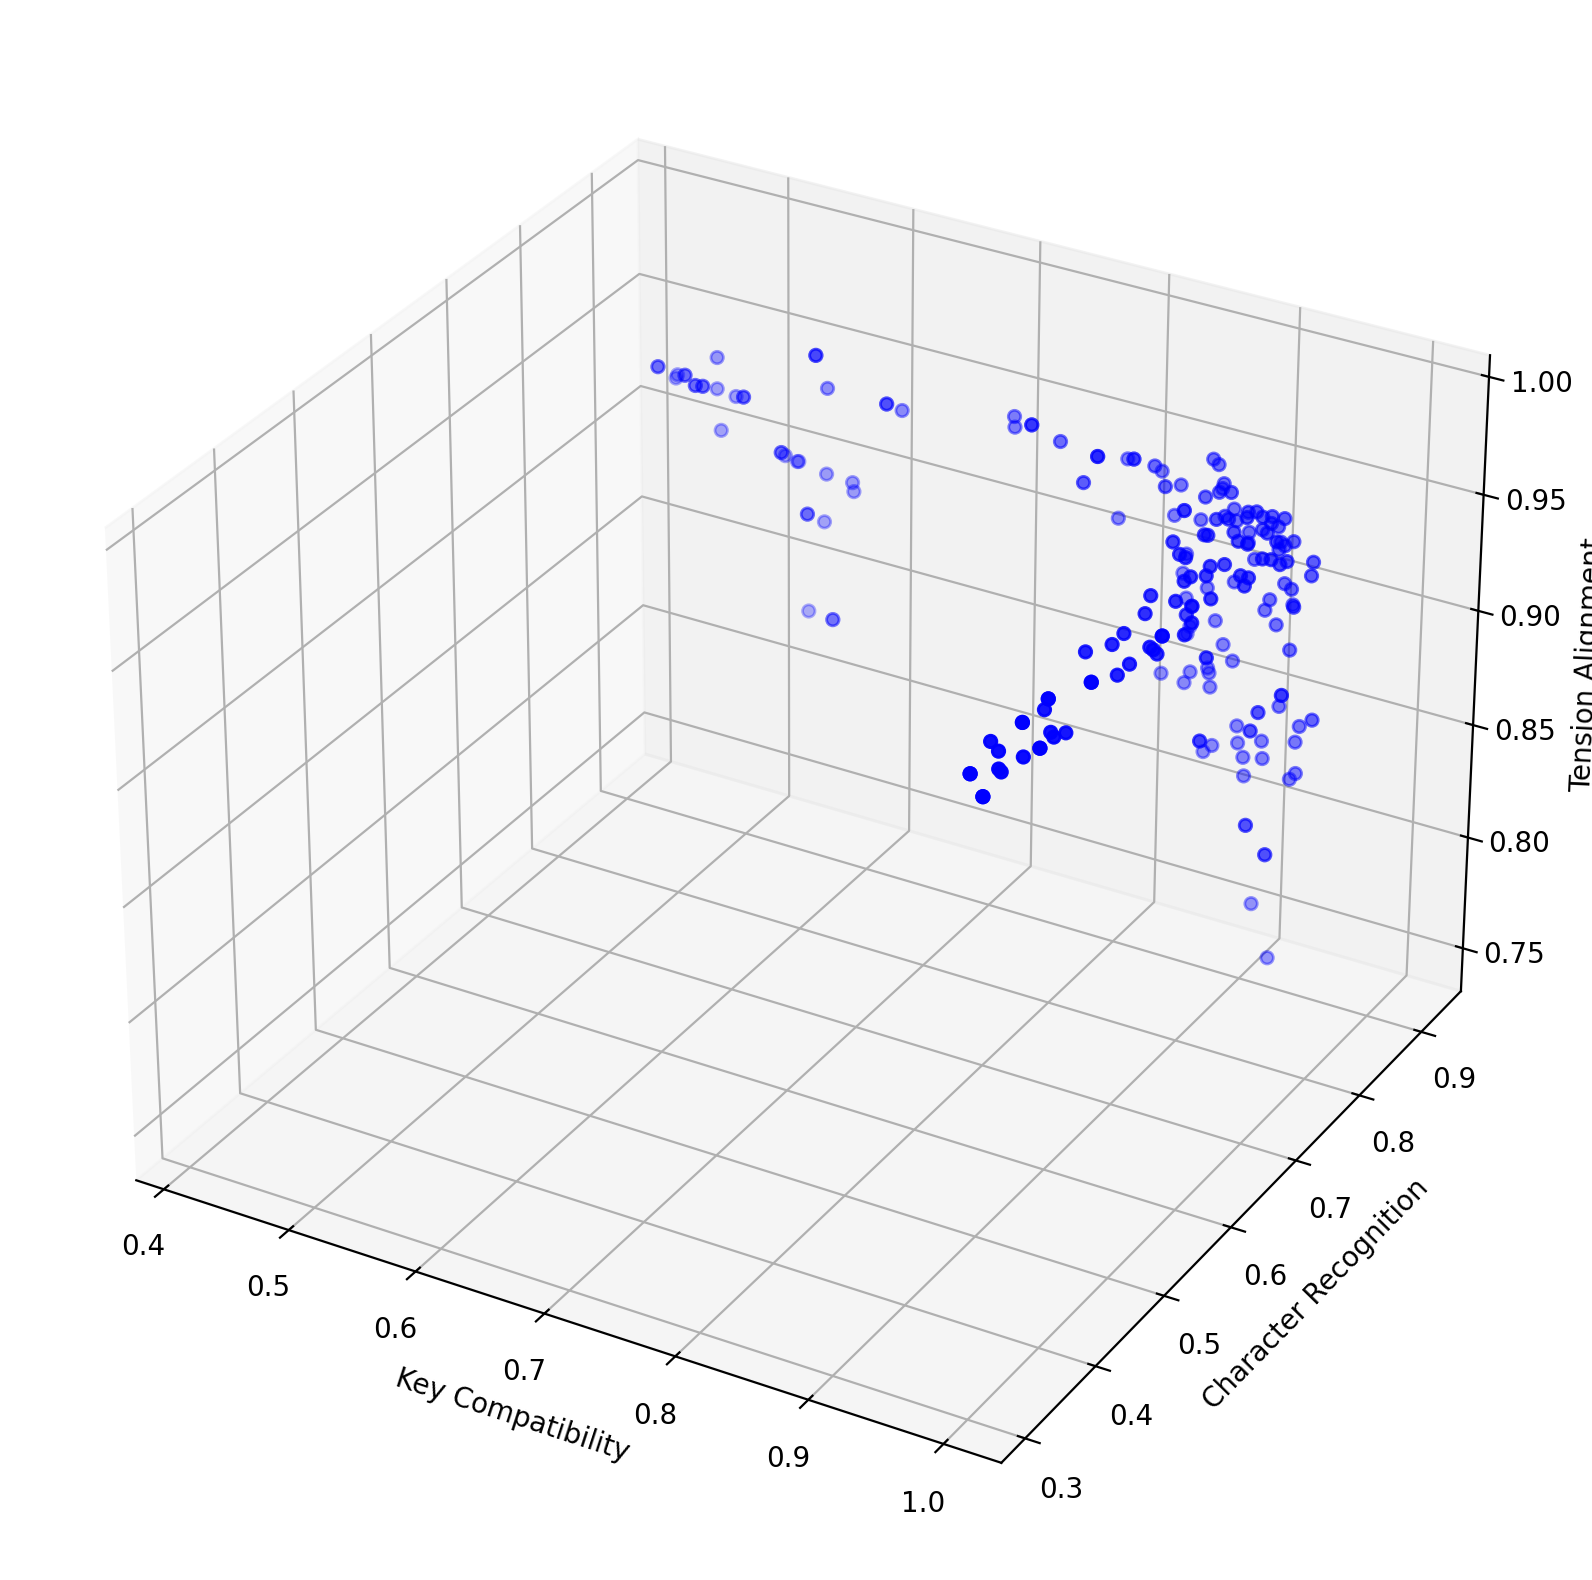

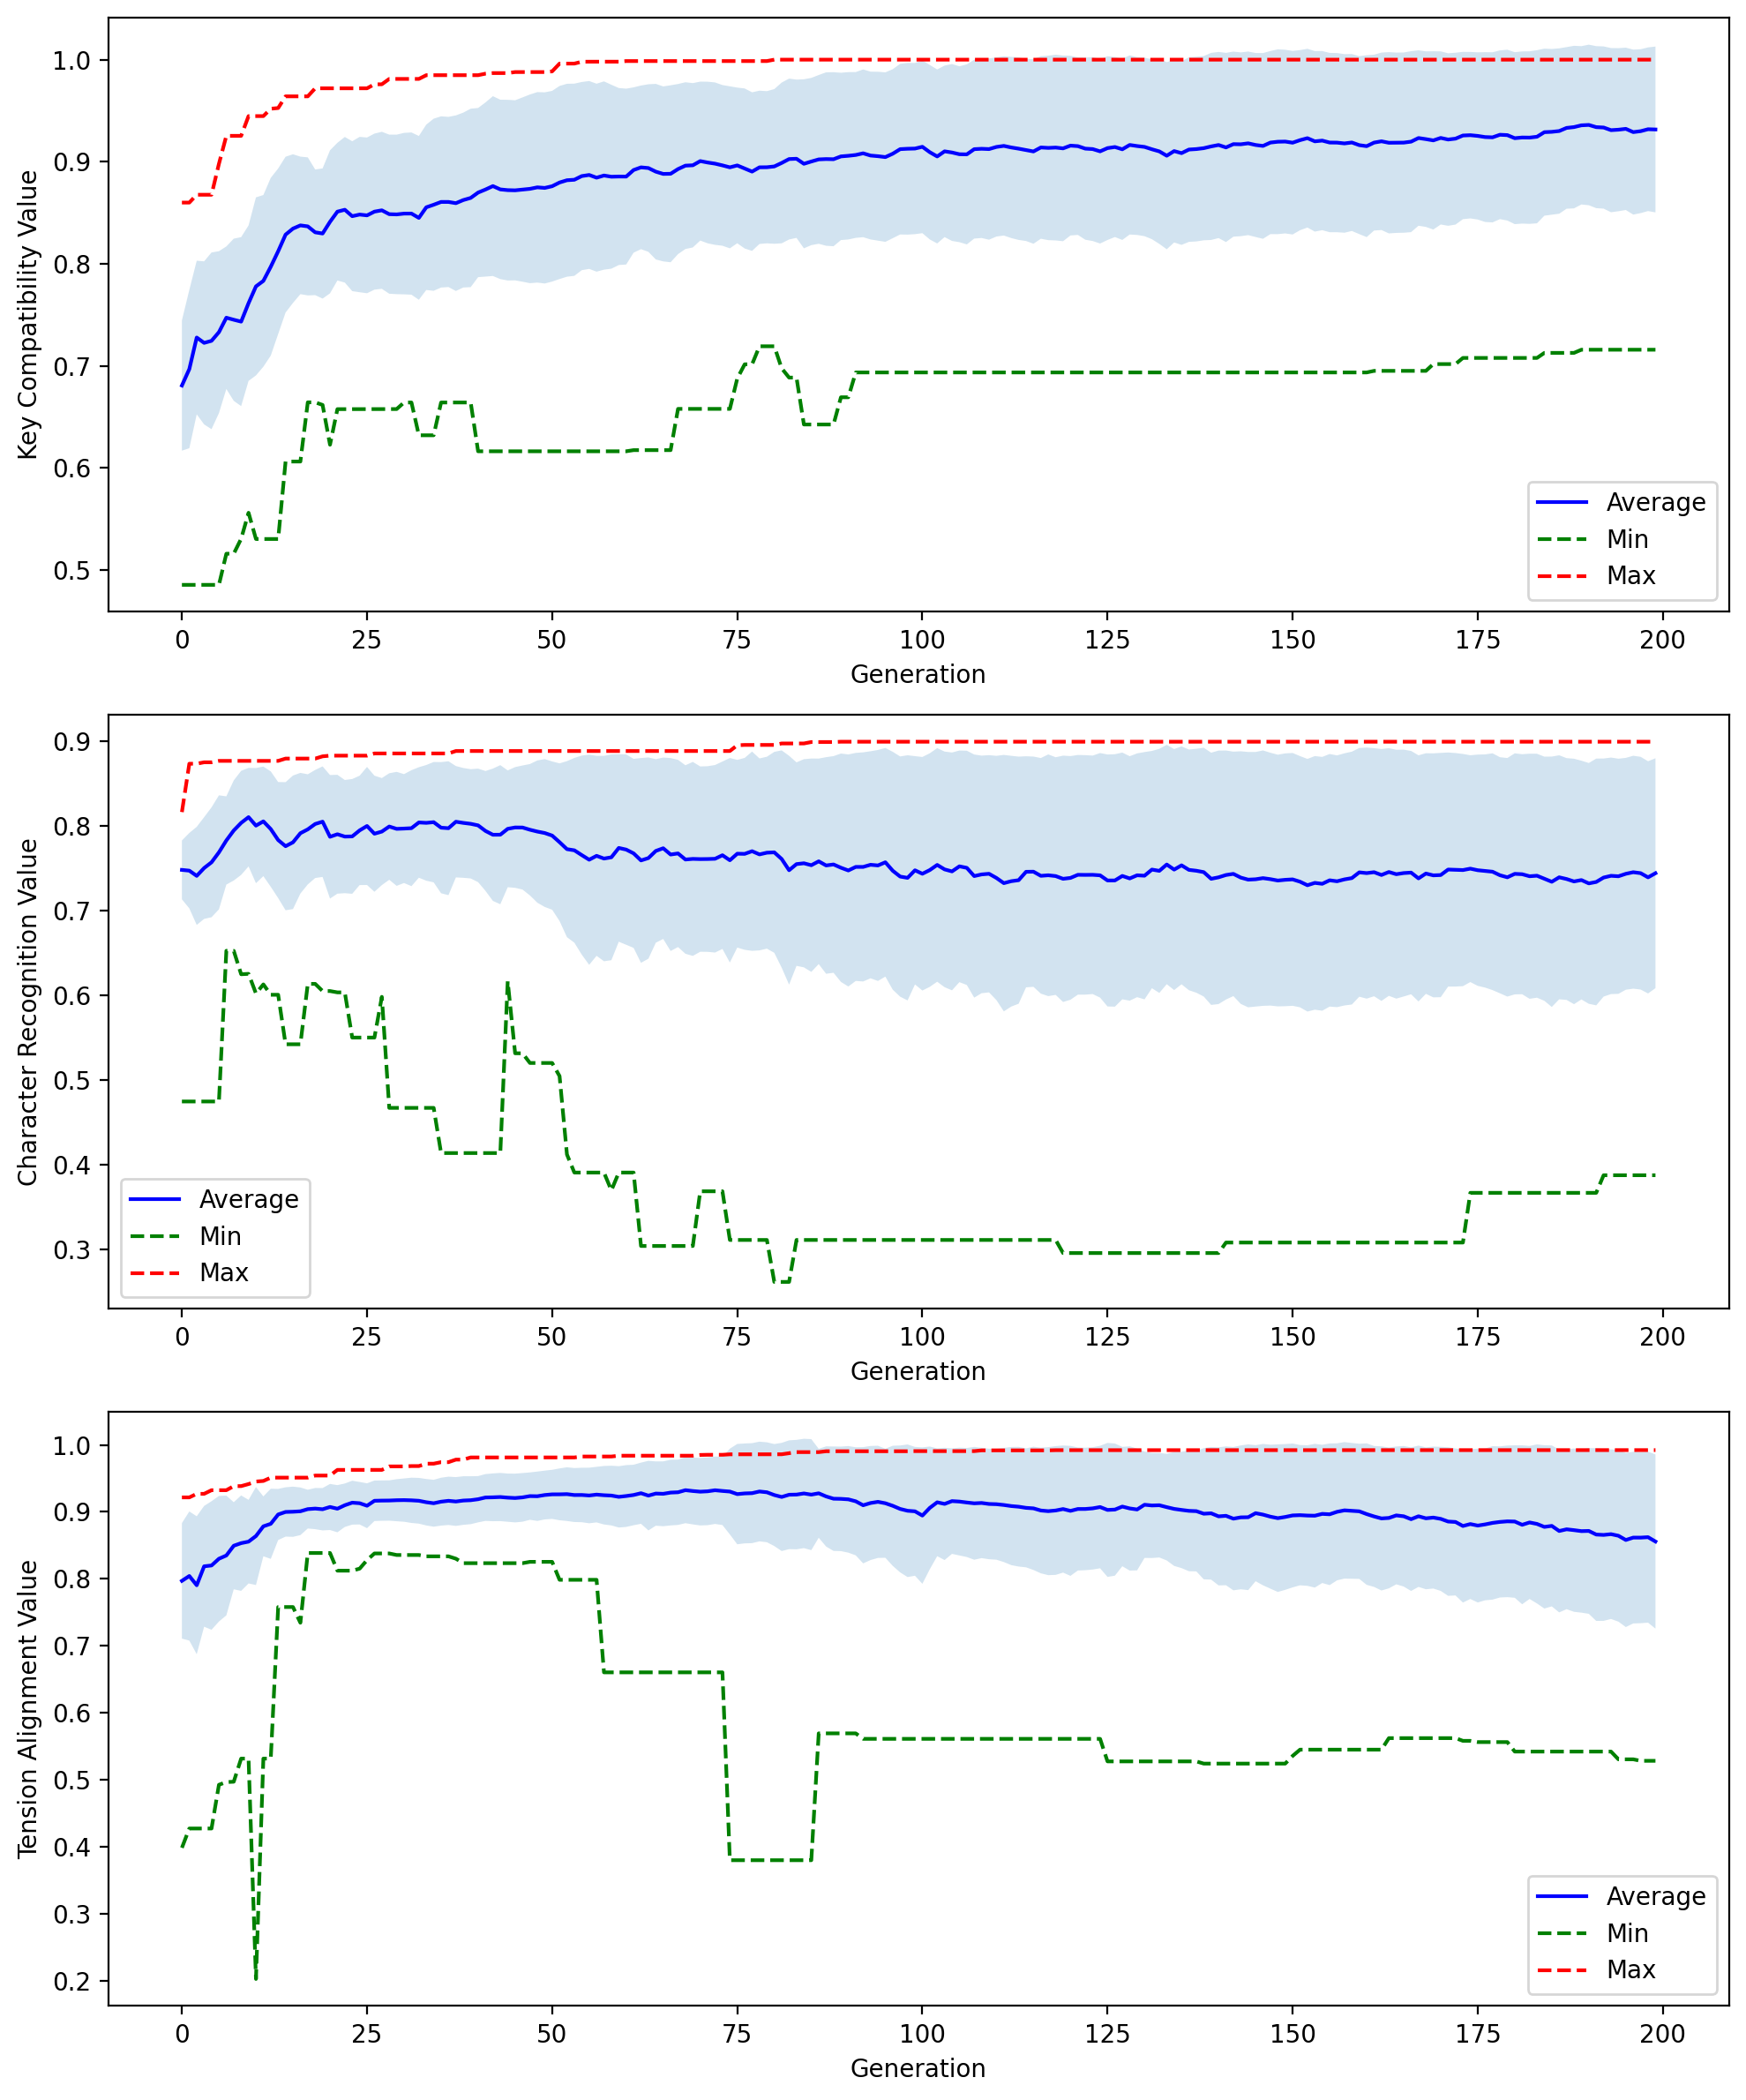

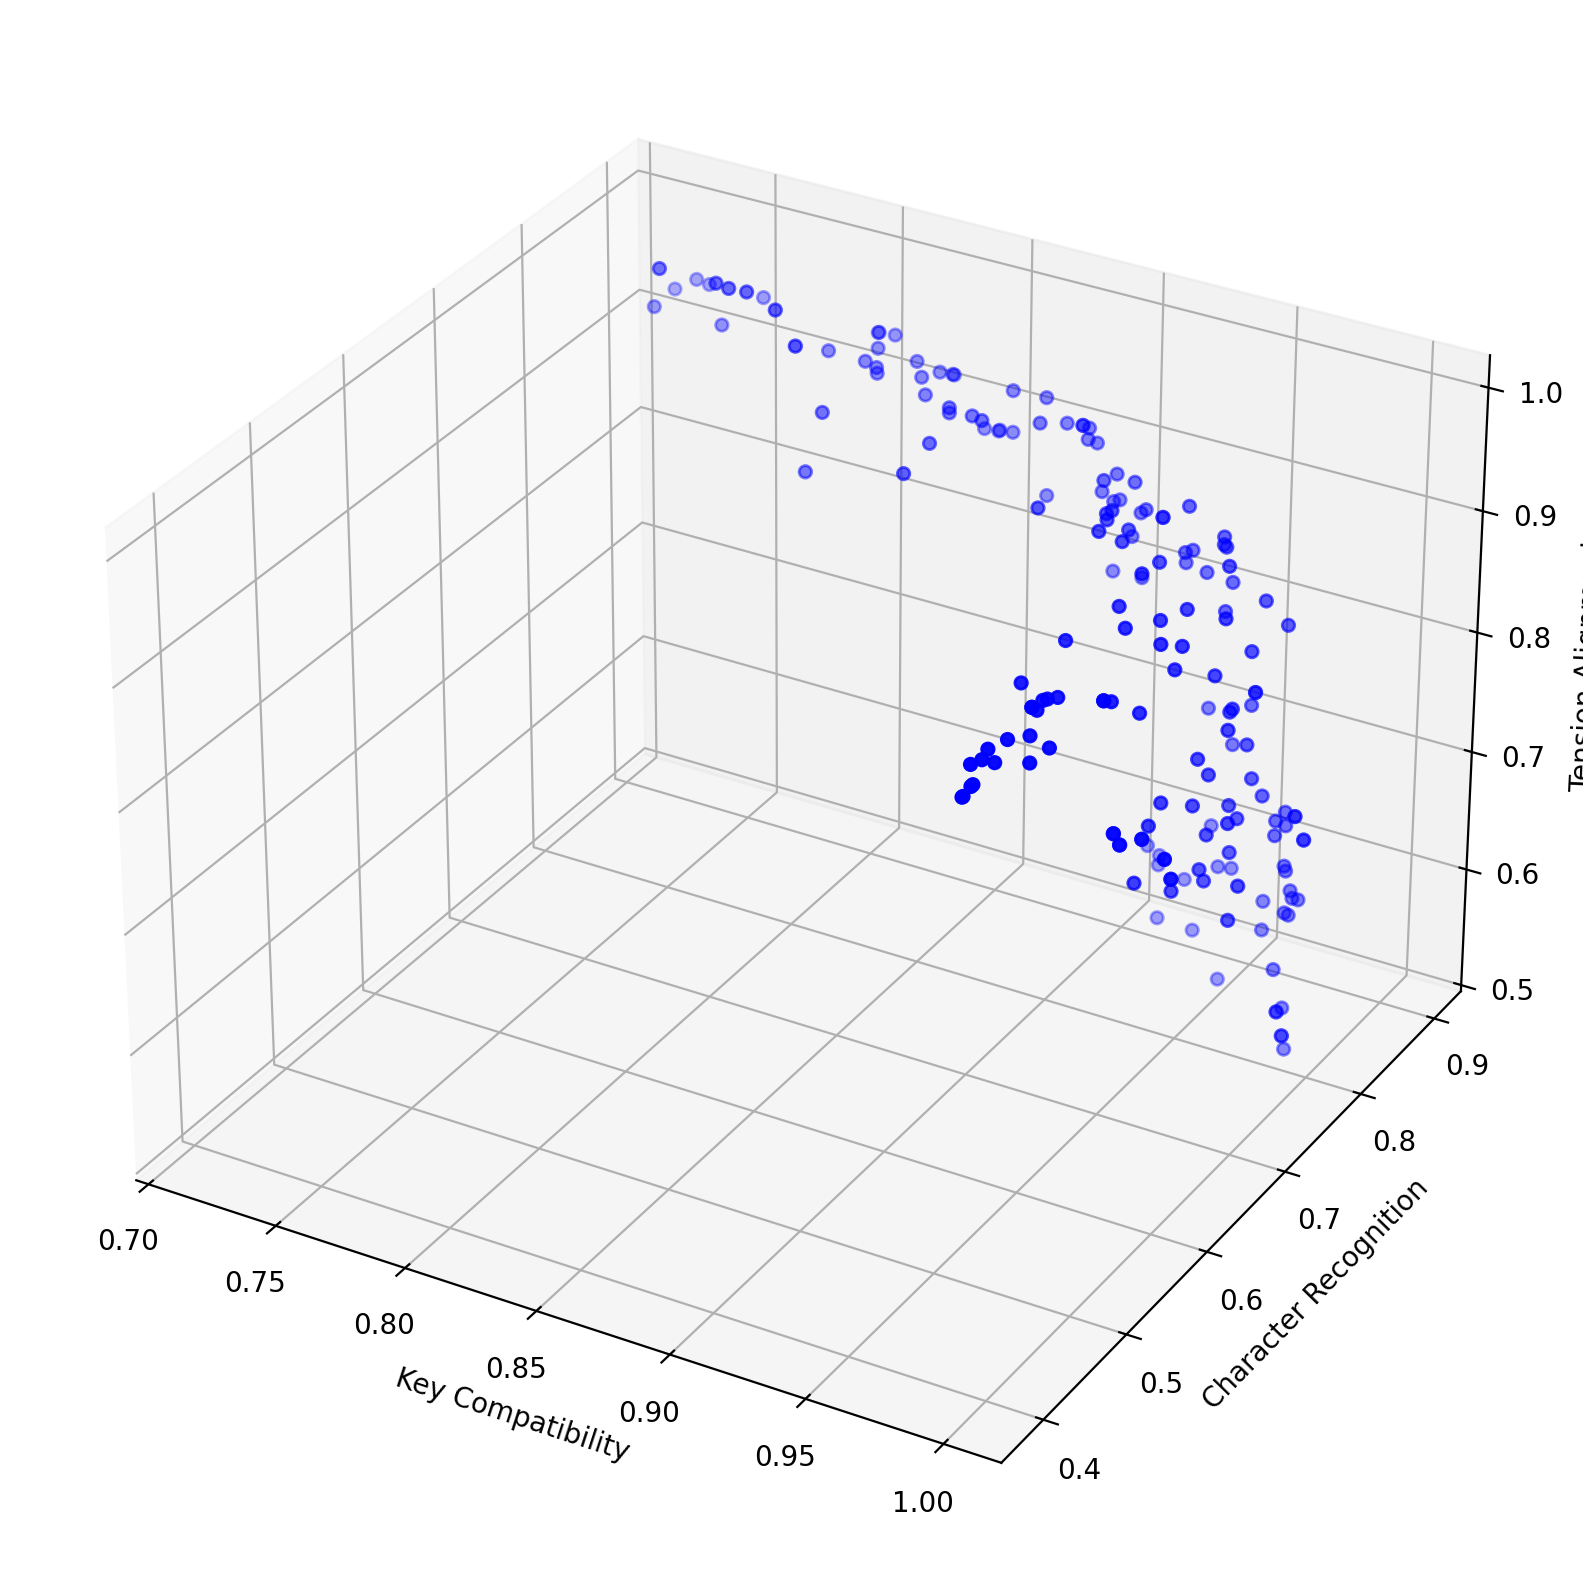

In [16]:
for i in range(len(nsga2s)):
    nsga2s[i].visualize_objectives(results[i][1])
    nsga2s[i].visualize_pareto_front(results[i][0])

## 8. Solution Selection Strategies
Several functions are defined to help select solutions from the Pareto front based on different criteria:
- `interactive_selection`: Allows manual exploration by showing top solutions for each objective.
- `select_by_weighted_preferences`: Selects a solution based on user-defined weights for each objective.
- `select_knee_point`: Selects the solution that represents the best trade-off (knee point).
- `select_compromise_solution`: Selects the solution closest to an ideal point.

In [17]:
def interactive_selection(pareto_front: List[Individual]) -> List[Individual]:
    """Allow user to explore and select from Pareto front"""
    print("Top 5 solutions for each objective:")
    
    objectives = ['Key', 'Character', 'Tension']
    solutions = {}
    for i, obj_name in enumerate(objectives):
        print(f"\nBest solutions for {obj_name}:")
        sorted_solutions = sorted(pareto_front, 
                                key=lambda x: x.objectives[i], 
                                reverse=True)
        solutions[obj_name] = sorted_solutions[:5]
        for j, sol in enumerate(sorted_solutions[:5]):
            print(f"Solution {j+1}:")
            print(f"  {obj_name}: {sol.objectives[i]:.3f}")
            print(f"  Other objectives: {[f'{v:.3f}' for k,v in enumerate(sol.objectives) if k != i]}")
    
    return solutions

def select_by_weighted_preferences(pareto_front: List[Individual], weights: List[float]) -> Individual:
    """Select solution using weighted preferences for objectives"""
    weights = np.array(weights) / sum(weights)
    
    scores = []
    for solution in pareto_front:
        weighted_score = sum(w * obj for w, obj in zip(weights, solution.objectives))
        scores.append(weighted_score)
    
    return pareto_front[np.argmax(scores)]

def select_knee_point(pareto_front: List[Individual]) -> Individual:
    """Select knee point solution - greatest marginal improvement"""
    obj_values = np.array([ind.objectives for ind in pareto_front])
    
    ideal_point = np.max(obj_values, axis=0)
    distances = np.linalg.norm(ideal_point - obj_values, axis=1)
    
    return pareto_front[np.argmin(distances)]

def select_compromise_solution(pareto_front: List[Individual]) -> Individual:
    """Select solution closest to ideal point"""
    obj_values = np.array([ind.objectives for ind in pareto_front])
    
    ideal_point = np.max(obj_values, axis=0)
    nadir_point = np.min(obj_values, axis=0)
    
    normalized_values = (obj_values - nadir_point) / (ideal_point - nadir_point + 1e-9) # Add epsilon to avoid division by zero
    
    distances = np.linalg.norm(1 - normalized_values, axis=1)
    
    return pareto_front[np.argmin(distances)]

In [18]:
pareto_fronts = [nsga2s[i].fast_non_dominated_sort(results[i][0])[0] for i in range(len(nsga2s))]

### 8.1. Applying Selection Strategies
Here, we demonstrate how to use these selection strategies. We start with interactive selection for the first plot atoms Pareto front.

In [19]:
solutions = interactive_selection(pareto_fronts[0])

Top 5 solutions for each objective:

Best solutions for Key:
Solution 1:
  Key: 1.000
  Other objectives: ['0.438', '0.801']
Solution 2:
  Key: 1.000
  Other objectives: ['0.300', '0.954']
Solution 3:
  Key: 1.000
  Other objectives: ['0.406', '0.874']
Solution 4:
  Key: 1.000
  Other objectives: ['0.207', '0.957']
Solution 5:
  Key: 1.000
  Other objectives: ['0.320', '0.912']

Best solutions for Character:
Solution 1:
  Character: 0.765
  Other objectives: ['0.754', '0.529']
Solution 2:
  Character: 0.765
  Other objectives: ['0.690', '0.779']
Solution 3:
  Character: 0.765
  Other objectives: ['0.700', '0.757']
Solution 4:
  Character: 0.764
  Other objectives: ['0.677', '0.783']
Solution 5:
  Character: 0.760
  Other objectives: ['0.670', '0.783']

Best solutions for Tension:
Solution 1:
  Tension: 0.995
  Other objectives: ['0.882', '0.207']
Solution 2:
  Tension: 0.994
  Other objectives: ['0.886', '0.168']
Solution 3:
  Tension: 0.994
  Other objectives: ['0.886', '0.168']
Solut

We can then listen to one of the selected solutions (e.g., one of the best for tension alignment).

In [20]:
play_individual_musescore(solutions['Tension'][0])

Next, we apply automated selection strategies (weighted sum, knee point, compromise) to all Pareto fronts.

In [21]:
weighted_sum_solutions = [select_by_weighted_preferences(pareto_front, [0.1, 0.8, 0.1]) for pareto_front in pareto_fronts]
knee_point_solutions = [select_knee_point(pareto_front) for pareto_front in pareto_fronts]
compromise_solutions = [select_compromise_solution(pareto_front) for pareto_front in pareto_fronts]

We can listen to the sequence of solutions chosen by the weighted sum method.

In [22]:
weighted_sum_solutions = [select_by_weighted_preferences(pareto_front, [0.1, 0.6, 0.3]) for pareto_front in pareto_fronts]
play_individuals_musescore(weighted_sum_solutions)

## 9. Advanced Selection and Ranking of Combined Solutions
To select a diverse set of good solutions for each part, we define `select_n_by_weighted_preferences`.

In [23]:
def select_n_by_weighted_preferences(pareto_front: List[Individual], weights: List[float], n: int = 1) -> List[Individual]:
    """Select n solutions using weighted preferences for objectives"""
    weights = np.array(weights) / sum(weights)
    
    scores = []
    for solution in pareto_front:
        weighted_score = sum(w * obj for w, obj in zip(weights, solution.objectives))
        scores.append(weighted_score)
    
    # Get indices of top n scores (argsort sorts in ascending order)
    top_n_indices = np.argsort(scores)[-n:]
    # Return in descending order of scores
    return [pareto_front[i] for i in top_n_indices[::-1]]

In [24]:
weighted_sum_solutions_n = [select_n_by_weighted_preferences(pareto_front, [0.1, 0.6, 0.3], 20) for pareto_front in pareto_fronts]

Finally, we define `rank_tension_combinations` to evaluate and rank combinations of solutions (one for each plot atom) based on how well their combined tension aligns with the overall narrative tension curve.

In [25]:
def rank_tension_combinations(solutions_per_part: List[List[Individual]], 
                            key: Key, 
                            plot_tension: List[float]) -> List[Tuple[List[Individual], float]]:
    """Rank all combinations by tension alignment score"""
    
    combinations_with_scores = []
    # Use itertools.product to get all combinations
    for combination in itertools.product(*solutions_per_part):
        nodes = [ind.musical_node for ind in combination]
        score = calculate_tension_alignment_span(nodes, key, plot_tension)
        combinations_with_scores.append((list(combination), score))
    
    ranked_combinations = sorted(combinations_with_scores, 
                               key=lambda x: x[1], 
                               reverse=True)
    
    return ranked_combinations

In [26]:
ranked_solutions = rank_tension_combinations(weighted_sum_solutions_n, protagonist_key, span_tension.interpolate(total_bars*4*4)[1]) # Interpolate to match total length
for i, (combination, score) in enumerate(ranked_solutions[:10]):  
    print(f"Rank {i+1}: Score = {score:.4f}")

Rank 1: Score = 0.8764
Rank 2: Score = 0.8756
Rank 3: Score = 0.8747
Rank 4: Score = 0.8746
Rank 5: Score = 0.8746
Rank 6: Score = 0.8745
Rank 7: Score = 0.8745
Rank 8: Score = 0.8741
Rank 9: Score = 0.8740
Rank 10: Score = 0.8739


We can then listen to the top-ranked full musical piece.

In [27]:
if ranked_solutions: play_individuals_musescore(ranked_solutions[0][0])

## 10. Conclusion
This notebook demonstrated a pipeline for generating music that aligns with narrative structures using a multi-objective genetic algorithm. By defining objectives related to musical theory, motif clarity, and narrative tension, the system can produce a variety of musical solutions that can then be selected and combined to form a complete piece.